In [1]:
import pathlib
import time

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import google

matplotlib.rcParams.update({
    'figure.dpi': 150,
    'font.size': 8,
})

DATA_DIR = 'ml10_mt10_csv'

data_dir = pathlib.Path(DATA_DIR)
data_dir.mkdir(exist_ok=True)

In [2]:
def fixup_dataframe(df, exp_id, test=False):
    for col in df.columns:
    # We need to rename
    # Rename successRate for ML10/45 (average training success rate over all tasks for ML)
        if exp_id.startswith('rl2'):
            df.rename(columns={'Average/SuccessRate': 'SuccessRate'}, inplace=True)
            df.rename(columns={'MetaTest/Average/SuccessRate': 'TestSuccessRate'}, inplace=True)
        elif exp_id.startswith('maml'):
            df.rename(columns={'Average/SuccessRate': 'SuccessRate'}, inplace=True)
            df.rename(columns={'MetaTest/Average/SuccessRate': 'TestSuccessRate'}, inplace=True)
            # Fix -1 in success rate
            df[df.filter(regex='SuccessRate').columns].applymap(lambda x: np.nan if x == -1 else x)
        elif exp_id.startswith('mtsac'):
            df.rename(columns={'Average/SuccessRate': 'SuccessRate'}, inplace=True)
        elif exp_id.startswith('mttrpo'):
            df.rename(columns={'Evaluation/SuccessRate': 'SuccessRate'}, inplace=True)

    # Multiply by 100 for 100%
    if "SuccessRate" in df.columns:
        df['SuccessRate'] = df['SuccessRate'].apply(lambda x: 100.0 * x)
    if 'TestSuccessRate' in df.columns:
        df['TestSuccessRate'] = df['TestSuccessRate'].apply(lambda x: 100.0 * x)
    return df

In [3]:
LOAD_EXPERIMENTS_MT10 = [
    'mtsac_metaworld_mt10_seed=8175',
    'mtsac_metaworld_mt10_seed=9798',
    'mtsac_metaworld_mt10_seed=2534',
    'mtsac_metaworld_mt10_seed=7458',
    'mtsac_metaworld_mt10_seed=9204',
]

LOAD_EXPERIMENTS_ML10 = [
    'rl2_ppo_metaworld_ml10_seed=8516',
    'rl2_ppo_metaworld_ml10_seed=3352',
    'rl2_ppo_metaworld_ml10_seed=5592',
    'rl2_ppo_metaworld_ml10_seed=2181',
    'rl2_ppo_metaworld_ml10_seed=4322',
#     'maml_trpo_metaworld_ml10_seed=7166',
#     'maml_trpo_metaworld_ml10_seed=902',
#     'maml_trpo_metaworld_ml10_seed=8946',
#     'maml_trpo_metaworld_ml10_seed=9227',
#     'maml_trpo_metaworld_ml10_seed=6267',
    'maml_trpo_metaworld_ml10_seed=6856_il=0.5',
    'maml_trpo_metaworld_ml10_seed=6911_il=0.5',
    'maml_trpo_metaworld_ml10_seed=3748_il=0.5',
    'maml_trpo_metaworld_ml10_seed=5730_il=0.5',
    'maml_trpo_metaworld_ml10_seed=6033_il=0.5',
]

exp_df = {}

In [4]:
# Load experiment data from S3

def load_experiments(experiments_list, data_directory):
    dfs = {}
    for e in experiments_list:
        print('Loading {}...'.format(e)) 
        progress = data_directory / f'{e}.csv'
        df = pd.read_csv(progress)
        df = fixup_dataframe(df, e)
        dfs[e] = df
    return dfs

In [5]:
exp_df.update(load_experiments(LOAD_EXPERIMENTS_MT10))
exp_df.update(load_experiments(LOAD_EXPERIMENTS_ML10))

Loading mtsac_metaworld_mt10_seed=8175...
Loading mtsac_metaworld_mt10_seed=9798...
Loading mtsac_metaworld_mt10_seed=2534...
Loading mtsac_metaworld_mt10_seed=7458...
Loading mtsac_metaworld_mt10_seed=9204...
Loading rl2_ppo_metaworld_ml10_seed=8516...
Loading rl2_ppo_metaworld_ml10_seed=3352...
Loading rl2_ppo_metaworld_ml10_seed=5592...
Loading rl2_ppo_metaworld_ml10_seed=2181...
Loading rl2_ppo_metaworld_ml10_seed=4322...
Loading maml_trpo_metaworld_ml10_seed=6856_il=0.5...
Loading maml_trpo_metaworld_ml10_seed=6911_il=0.5...
Loading maml_trpo_metaworld_ml10_seed=3748_il=0.5...
Loading maml_trpo_metaworld_ml10_seed=5730_il=0.5...
Loading maml_trpo_metaworld_ml10_seed=6033_il=0.5...


In [6]:
exp_df.keys()



dict_keys(['mtsac_metaworld_mt10_seed=8175', 'mtsac_metaworld_mt10_seed=9798', 'mtsac_metaworld_mt10_seed=2534', 'mtsac_metaworld_mt10_seed=7458', 'mtsac_metaworld_mt10_seed=9204', 'rl2_ppo_metaworld_ml10_seed=8516', 'rl2_ppo_metaworld_ml10_seed=3352', 'rl2_ppo_metaworld_ml10_seed=5592', 'rl2_ppo_metaworld_ml10_seed=2181', 'rl2_ppo_metaworld_ml10_seed=4322', 'maml_trpo_metaworld_ml10_seed=6856_il=0.5', 'maml_trpo_metaworld_ml10_seed=6911_il=0.5', 'maml_trpo_metaworld_ml10_seed=3748_il=0.5', 'maml_trpo_metaworld_ml10_seed=5730_il=0.5', 'maml_trpo_metaworld_ml10_seed=6033_il=0.5'])

Plotting MT-SAC...
Plotting MAML-TRPO...
Plotting RL${}^2$-PPO...


(0.0, 60000000.0)

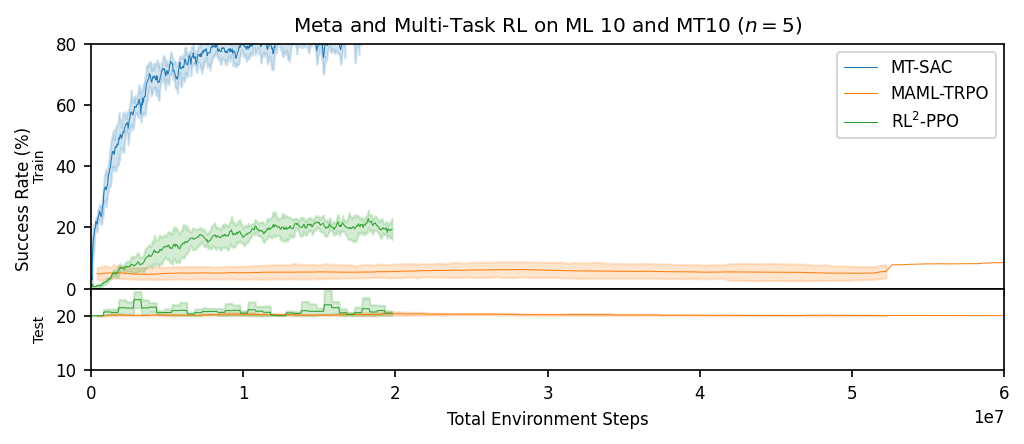

In [11]:
# Seed sensitivity
fig1, axs = plt.subplots(2, 
                         sharex=True,
                         figsize=(6.75,3), # use (6.5, 4) for single-column figures
                         tight_layout=True,
                         gridspec_kw={'height_ratios': [3, 1], 'hspace': 0}
                         ) 
train_ax, test_ax = axs

plot_data = {
    'MT-SAC': [
        'mtsac_metaworld_mt10_seed=8175',
        'mtsac_metaworld_mt10_seed=9798',
        'mtsac_metaworld_mt10_seed=2534',
        'mtsac_metaworld_mt10_seed=7458',
        'mtsac_metaworld_mt10_seed=9204',
    ],
   'MAML-TRPO': [

        'maml_trpo_metaworld_ml10_seed=6856_il=0.5',
        'maml_trpo_metaworld_ml10_seed=6911_il=0.5',
        'maml_trpo_metaworld_ml10_seed=3748_il=0.5',
        'maml_trpo_metaworld_ml10_seed=5730_il=0.5',
        'maml_trpo_metaworld_ml10_seed=6033_il=0.5',
    ],
    'RL${}^2$-PPO': [
        'rl2_ppo_metaworld_ml10_seed=8516',
        'rl2_ppo_metaworld_ml10_seed=3352',
        'rl2_ppo_metaworld_ml10_seed=5592',
        'rl2_ppo_metaworld_ml10_seed=2181',
        'rl2_ppo_metaworld_ml10_seed=4322',
    ],

}

# Smoothing spans
smooth = {
    'MAML-TRPO': 40,
    'MT-PPO': 5, 
    'MT-TRPO': 5,
    'MT-SAC': 5,
    'PEARL-SAC': 40,
    'RL${}^2$-PPO': 10,
    'TE-PPO': 5,
}

smooth1 = {
    'MAML-TRPO': 0,
    'MT-PPO': 5, 
    'MT-TRPO': 5,
    'MT-SAC': 5,
    'PEARL-SAC': 40,
    'RL${}^2$-PPO': 10,
    'TE-PPO': 5,
}
group_df = None
# Plot
labels = []
for name, group in plot_data.items():
    print('Plotting {}...'.format(name))
    dfs = [exp_df[e].copy() for e in group]

#     for e in group:
    # Smoothing
    dfs = [df.ewm(span=smooth[name]).mean() for df in dfs]

    # Combined dataframe
    group_df = pd.concat(dfs, keys=group, sort=True)

    # Plot train with 95% confidence interval
    train_rval = sns.lineplot(x='TotalEnvSteps', y='SuccessRate', ax=train_ax, data=group_df, ci=95, lw=0.5)
    train_color = train_ax.get_lines()[-1].get_color()
    labels.append(name)

    if 'TestSuccessRate' in group_df.columns:
        sns.lineplot(x='TotalEnvSteps', y='TestSuccessRate', ax=test_ax, data=group_df, ci=95, lw=0.5, 
                     color=train_color)


train_ax.set_title(r'Meta and Multi-Task RL on ML 10 and MT10 ($n=5$)')
train_ax.set_ylabel('Train', fontsize='small')
train_ax.legend(labels, loc='upper right')
train_ax.set_ylim([0, 80])
test_ax.set_ylabel('Test', fontsize='small')
test_ax.set_ylim([10, 25])
plt.figtext(0, 0.40, 'Success Rate (%)', rotation='vertical', in_layout=True)
plt.xlabel('Total Environment Steps')
plt.xlim([0, 60e6])

In [10]:

fig1.show()
fig1.savefig('seed_sensitivity_ml10_mt10.png', pad_inches=0, dpi=300)

In [73]:
ls

jupyter/                          step_bullet_kuka_env.py*
ml10_mt10_csv/                    step_dm_control_env.py*
ML10_MT10_V2_success_plots.ipynb  step_gym_env.py*
np/                               tf/
seed_sensitivity_ml10_mt10.pdf    torch/
sim_policy.py*


In [37]:
LOAD_EXPERIMENTS_MT10_V1 = [
    'MTSAC_MT10_vanilla-RI_v1_0',
    'MTSAC_MT10_vanilla-RI_v1_1',
    'MTSAC_MT10_vanilla-RI_v1_2',
    'MTSAC_MT10_vanilla-RI_v1_3',
]

LOAD_EXPERIMENTS_ML10_V1 = [
    'MAMLTRPO_ML10_best_0-v1',
    'MAMLTRPO_ML10_best_1-v1',
    'MAMLTRPO_ML10_best_2-v1',
    'MAMLTRPO_ML10_best_3-v1',
    'MAMLTRPO_ML10_best_4-v1',
    'RL2TRPO_ML10_0_v1',
    'RL2TRPO_ML10_1_v1',
    'RL2TRPO_ML10_2_v1',
    'RL2TRPO_ML10_3_v1',
    'RL2TRPO_ML10_4_v1',
]

# exp_df_v1 = {}
# exp_df.update(load_experiments(LOAD_EXPERIMENTS_MT10_V1))
# exp_df.update(load_experiments(LOAD_EXPERIMENTS_ML10_V1))


In [38]:
def fixup_dataframe_v1(df, exp_id, test=False):
    for col in df.columns:
    # We need to rename
    # Rename successRate for ML10/45 (average training success rate over all tasks for ML)
        if not test:
            if exp_id.startswith('RL2'):
                df.rename(columns={'Evaluation/SuccessRate': 'SuccessRate'}, inplace=True)
            elif exp_id.startswith('MAML'):
                df.rename(columns={'Average/SuccessRate': 'SuccessRate'}, inplace=True)
            # Fix -1 in success rate
                df[df.filter(regex='SuccessRate').columns].applymap(lambda x: np.nan if x == -1 else x)
            elif exp_id.startswith('PEARL'):
                df.rename(columns={'Train/Average/SuccessRate': 'SuccessRate'}, inplace=True)
                df.rename(columns={'Test/Average/SuccessRate': 'TestSuccessRate'}, inplace=True)
            # Fix -1 in success rate
                df[df.filter(regex='SuccessRate').columns].applymap(lambda x: np.nan if x == -1 else x)
            elif exp_id.startswith('MTSAC'):
                df.rename(columns={'local/Mean_SuccessRate': 'SuccessRate'}, inplace=True)
            elif exp_id.startswith('MTPPO') or exp_id.startswith('MTTRPO'):
                # Add success rate for MT10/50 (average success rate over all tasks)
                df['SuccessRate'] = df.filter(regex='SuccessRate').mean(axis=1)

    # Multiply by 100 for 100%
    if "SuccessRate" in df.columns:
        df['SuccessRate'] = df['SuccessRate'].apply(lambda x: 100.0 * x)
    if 'TestSuccessRate' in df.columns:
        df['TestSuccessRate'] = df['TestSuccessRate'].apply(lambda x: 100.0 * x)
    return df

In [39]:
# Load experiment data from S3

def load_experiments_v1(experiments_list):
    dfs = {}
    for e in experiments_list:
        print('Loading {}...'.format(e)) 
        progress = data_dir / f'{e}.csv'
        df = pd.read_csv(progress)
        df = fixup_dataframe_v1(df, e)
        dfs[e] = df
    return dfs

In [40]:
exp_df.update(load_experiments_v1(LOAD_EXPERIMENTS_MT10_V1))
exp_df.update(load_experiments_v1(LOAD_EXPERIMENTS_ML10_V1))

Loading MTSAC_MT10_vanilla-RI_v1_0...
Loading MTSAC_MT10_vanilla-RI_v1_1...
Loading MTSAC_MT10_vanilla-RI_v1_2...
Loading MTSAC_MT10_vanilla-RI_v1_3...
Loading MAMLTRPO_ML10_best_0-v1...
Loading MAMLTRPO_ML10_best_1-v1...
Loading MAMLTRPO_ML10_best_2-v1...
Loading MAMLTRPO_ML10_best_3-v1...
Loading MAMLTRPO_ML10_best_4-v1...
Loading RL2TRPO_ML10_0_v1...
Loading RL2TRPO_ML10_1_v1...
Loading RL2TRPO_ML10_2_v1...
Loading RL2TRPO_ML10_3_v1...
Loading RL2TRPO_ML10_4_v1...


In [27]:
exp_df.keys()

dict_keys(['mtsac_metaworld_mt10_seed=8175', 'mtsac_metaworld_mt10_seed=9798', 'mtsac_metaworld_mt10_seed=2534', 'mtsac_metaworld_mt10_seed=7458', 'mtsac_metaworld_mt10_seed=9204', 'rl2_ppo_metaworld_ml10_seed=8516', 'rl2_ppo_metaworld_ml10_seed=3352', 'rl2_ppo_metaworld_ml10_seed=5592', 'rl2_ppo_metaworld_ml10_seed=2181', 'rl2_ppo_metaworld_ml10_seed=4322', 'maml_trpo_metaworld_ml10_seed=6856_il=0.5', 'maml_trpo_metaworld_ml10_seed=6911_il=0.5', 'maml_trpo_metaworld_ml10_seed=3748_il=0.5', 'maml_trpo_metaworld_ml10_seed=5730_il=0.5', 'maml_trpo_metaworld_ml10_seed=6033_il=0.5', 'MTSAC_MT10_vanilla-RI_v1_0', 'MTSAC_MT10_vanilla-RI_v1_1', 'MTSAC_MT10_vanilla-RI_v1_2', 'MTSAC_MT10_vanilla-RI_v1_3', 'MAMLTRPO_ML10_best_0-v1', 'MAMLTRPO_ML10_best_1-v1', 'MAMLTRPO_ML10_best_2-v1', 'MAMLTRPO_ML10_best_3-v1', 'MAMLTRPO_ML10_best_4-v1', 'RL2TRPO_ML10_0_v1', 'RL2TRPO_ML10_1_v1', 'RL2TRPO_ML10_2_v1', 'RL2TRPO_ML10_3_v1', 'RL2TRPO_ML10_4_v1'])

Plotting MAML-TRPO-V2...
Plotting MAML-TRPO-V1...


/home/avnish/miniconda3/envs/garage/lib/python3.7/site-packages/ipykernel_launcher.py:125: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.


(0.0, 60000000.0)

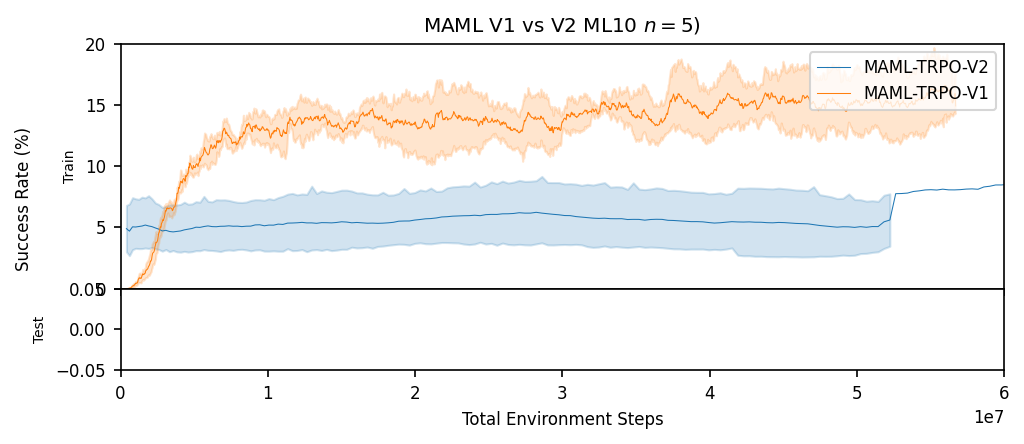

In [47]:
# Seed sensitivity
fig1, axs = plt.subplots(2, 
                         sharex=True,
                         figsize=(6.75,3), # use (6.5, 4) for single-column figures
                         tight_layout=True,
                         gridspec_kw={'height_ratios': [3, 1], 'hspace': 0}
                         ) 
train_ax, test_ax = axs

plot_data = {
    
#     'RL${}^2$-PPO-V2': [
#         'rl2_ppo_metaworld_ml10_seed=8516',
#         'rl2_ppo_metaworld_ml10_seed=3352',
#         'rl2_ppo_metaworld_ml10_seed=5592',
#         'rl2_ppo_metaworld_ml10_seed=2181',
#         'rl2_ppo_metaworld_ml10_seed=4322',
#     ],
    
#     'RL${}^2$-PPO-V1': [
#         'RL2TRPO_ML10_0_v1',
#         'RL2TRPO_ML10_1_v1',
#         'RL2TRPO_ML10_2_v1',
#         'RL2TRPO_ML10_3_v1',
#         'RL2TRPO_ML10_4_v1',
#     ],
#     'MT-SAC-V2': [
#         'mtsac_metaworld_mt10_seed=8175',
#         'mtsac_metaworld_mt10_seed=9798',
#         'mtsac_metaworld_mt10_seed=2534',
#         'mtsac_metaworld_mt10_seed=7458',
#         'mtsac_metaworld_mt10_seed=9204',
#     ],
    
#     'MT-SAC-V1': [
#         'MTSAC_MT10_vanilla-RI_v1_0',
#         'MTSAC_MT10_vanilla-RI_v1_1',
#         'MTSAC_MT10_vanilla-RI_v1_2',
#         'MTSAC_MT10_vanilla-RI_v1_3',
#     ],
#     'MT-SAC-V2': [
#         'mtsac_metaworld_mt10_seed=8175',
#         'mtsac_metaworld_mt10_seed=9798',
#         'mtsac_metaworld_mt10_seed=2534',
#         'mtsac_metaworld_mt10_seed=7458',
#         'mtsac_metaworld_mt10_seed=9204',
#     ],
    
#     'MT-SAC-V1': [
#         'MTSAC_MT10_vanilla-RI_v1_0',
#         'MTSAC_MT10_vanilla-RI_v1_1',
#         'MTSAC_MT10_vanilla-RI_v1_2',
#         'MTSAC_MT10_vanilla-RI_v1_3',
#     ],
    'MAML-TRPO-V2': [
        'maml_trpo_metaworld_ml10_seed=6856_il=0.5',
        'maml_trpo_metaworld_ml10_seed=6911_il=0.5',
        'maml_trpo_metaworld_ml10_seed=3748_il=0.5',
        'maml_trpo_metaworld_ml10_seed=5730_il=0.5',
        'maml_trpo_metaworld_ml10_seed=6033_il=0.5',
    ],
    'MAML-TRPO-V1': [

        'MAMLTRPO_ML10_best_0-v1',
        'MAMLTRPO_ML10_best_1-v1',
        'MAMLTRPO_ML10_best_2-v1',
        'MAMLTRPO_ML10_best_3-v1',
        'MAMLTRPO_ML10_best_4-v1',
    ],

}

# Smoothing spans
smooth = {
    'MAML-TRPO-V1': 40,
    'MAML-TRPO-V2': 40,
    'MT-PPO': 5, 
    'MT-TRPO': 5,
    'MT-SAC-V2': 5,
    'MT-SAC-V1': 5,
    'PEARL-SAC': 40,
    'RL${}^2$-PPO-V2': 10,
    'RL${}^2$-PPO-V1': 10,
    'TE-PPO': 5,
}

smooth1 = {
    'MAML-TRPO': 0,
    'MT-PPO': 5, 
    'MT-TRPO': 5,
    'MT-SAC': 5,
    'PEARL-SAC': 40,
    'RL${}^2$-PPO': 10,
    'TE-PPO': 5,
}
group_df = None
# Plot
labels = []
for name, group in plot_data.items():
    print('Plotting {}...'.format(name))
    dfs = [exp_df[e].copy() for e in group]

#     for e in group:
    # Smoothing
    dfs = [df.ewm(span=smooth[name]).mean() for df in dfs]

    # Combined dataframe
    group_df = pd.concat(dfs, keys=group, sort=True)

    # Plot train with 95% confidence interval
    train_rval = sns.lineplot(x='TotalEnvSteps', y='SuccessRate', ax=train_ax, data=group_df, ci=95, lw=0.5)
    train_color = train_ax.get_lines()[-1].get_color()
    labels.append(name)

    if 'TestSuccessRate' in group_df.columns:
        sns.lineplot(x='TotalEnvSteps', y='TestSuccessRate', ax=test_ax, data=group_df, ci=95, lw=0.5, 
                     color=train_color)


train_ax.set_title(r'MAML V1 vs V2 ML10 $n=5$)')
train_ax.set_ylabel('Train', fontsize='small')
train_ax.legend(labels, loc='upper right')
train_ax.set_ylim([0, 20])
test_ax.set_ylabel('Test', fontsize='small')
test_ax.set_ylim([0, 0])
plt.figtext(0, 0.40, 'Success Rate (%)', rotation='vertical', in_layout=True)
plt.xlabel('Total Environment Steps')
plt.xlim([0, 60e6])

In [36]:
fig1.show()
fig1.savefig('mtsac_v1_vs_v2_mt10.png', pad_inches=0, dpi=300)

In [17]:
'maml_trpo_metaworld_mt10_seed=2332_il=0.05_extra_tags=none.csv'
'maml_trpo_metaworld_mt10_seed=5326_il=0.05_extra_tags=none.csv'
'maml_trpo_metaworld_mt10_seed=838_il=0.05_extra_tags=none.csv'
'mttrpo_metaworld_mt10_seed=3813_epochs=2000_batch_size=5000_n_workers=10_n_tasks=10.csv'
'mttrpo_metaworld_mt10_seed=6160_epochs=2000_batch_size=5000_n_workers=10_n_tasks=10.csv'
'mttrpo_metaworld_mt10_seed=826_epochs=2000_batch_size=5000_n_workers=10_n_tasks=10.csv'

'mttrpo_metaworld_mt10_seed=826_epochs=2000_batch_size=5000_n_workers=10_n_tasks=10.csv'

# MTTRPO vs MAML with Reward Normalization on MT10

In [21]:
experiment_data=[
    'maml_trpo_metaworld_mt10_seed=2332_il=0.05_extra_tags=none',
    'maml_trpo_metaworld_mt10_seed=5326_il=0.05_extra_tags=none',
    'maml_trpo_metaworld_mt10_seed=838_il=0.05_extra_tags=none',
    'mttrpo_metaworld_mt10_seed=3813_epochs=2000_batch_size=5000_n_workers=10_n_tasks=10',
    'mttrpo_metaworld_mt10_seed=6160_epochs=2000_batch_size=5000_n_workers=10_n_tasks=10',
    'mttrpo_metaworld_mt10_seed=826_epochs=2000_batch_size=5000_n_workers=10_n_tasks=10',
]

In [22]:
DATA_DIR = 'mt10_maml_vs_mttrpo'

data_dir = pathlib.Path(DATA_DIR)
data_dir.mkdir(exist_ok=True)

exp_df = {}
def load_experiments(experiments_list, data_directory):
    dfs = {}
    for e in experiments_list:
        print('Loading {}...'.format(e)) 
        progress = data_directory / f'{e}.csv'
        df = pd.read_csv(progress)
        df = fixup_dataframe(df, e)
        dfs[e] = df
    return dfs



exp_df.update(load_experiments(experiment_data, data_dir))

Loading maml_trpo_metaworld_mt10_seed=2332_il=0.05_extra_tags=none...
Loading maml_trpo_metaworld_mt10_seed=5326_il=0.05_extra_tags=none...
Loading maml_trpo_metaworld_mt10_seed=838_il=0.05_extra_tags=none...
Loading mttrpo_metaworld_mt10_seed=3813_epochs=2000_batch_size=5000_n_workers=10_n_tasks=10...
Loading mttrpo_metaworld_mt10_seed=6160_epochs=2000_batch_size=5000_n_workers=10_n_tasks=10...
Loading mttrpo_metaworld_mt10_seed=826_epochs=2000_batch_size=5000_n_workers=10_n_tasks=10...


In [25]:
exp_df['mttrpo_metaworld_mt10_seed=3813_epochs=2000_batch_size=5000_n_workers=10_n_tasks=10']['SuccessRate']

0        0.0
1        0.0
2        0.0
3        0.0
4       10.0
        ... 
1995     0.0
1996     0.0
1997    20.0
1998     0.0
1999    10.0
Name: SuccessRate, Length: 2000, dtype: float64

Plotting MAML-TRPO-Reward-Normalized...
Plotting MTTRPO-Reward-Normalized...


(0.0, 90000000.0)

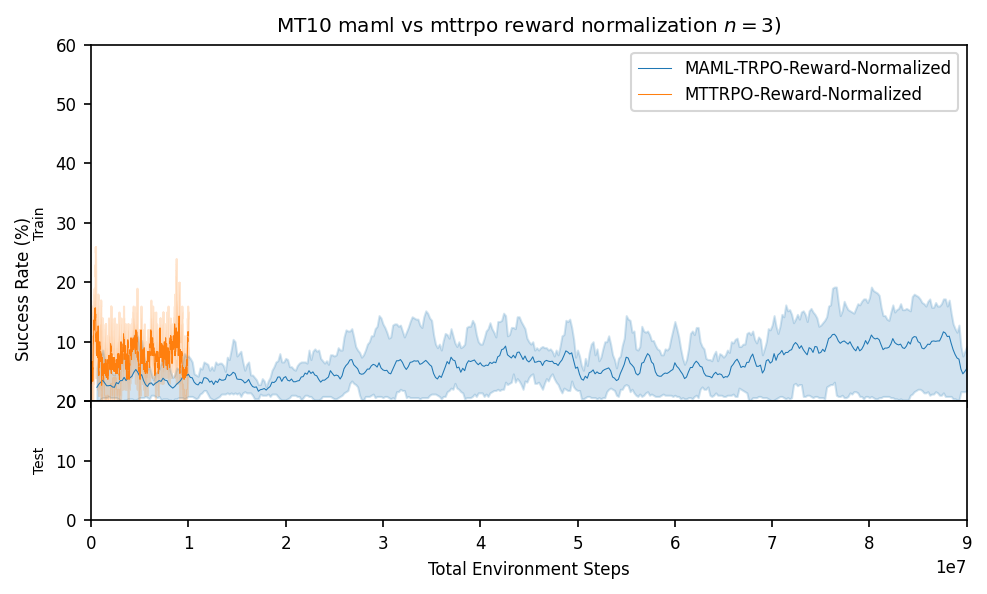

In [39]:
# Seed sensitivity
fig1, axs = plt.subplots(2, 
                         sharex=True,
                         figsize=(6.5,4), # use (6.5, 4) for single-column figures
                         tight_layout=True,
                         gridspec_kw={'height_ratios': [3, 1], 'hspace': 0}
                         ) 
train_ax, test_ax = axs

plot_data = {
    
    'MAML-TRPO-Reward-Normalized': [
        'maml_trpo_metaworld_mt10_seed=2332_il=0.05_extra_tags=none',
        'maml_trpo_metaworld_mt10_seed=5326_il=0.05_extra_tags=none',
        'maml_trpo_metaworld_mt10_seed=838_il=0.05_extra_tags=none',
        
    ],
    'MTTRPO-Reward-Normalized': [
        'mttrpo_metaworld_mt10_seed=3813_epochs=2000_batch_size=5000_n_workers=10_n_tasks=10',
        'mttrpo_metaworld_mt10_seed=6160_epochs=2000_batch_size=5000_n_workers=10_n_tasks=10',
        'mttrpo_metaworld_mt10_seed=826_epochs=2000_batch_size=5000_n_workers=10_n_tasks=10',
    ],

}

# Smoothing spans
smooth = {
    'MTTRPO-Reward-Normalized': 10,
    'MAML-TRPO-Reward-Normalized': 5,
}

group_df = None
# Plot
labels = []
for name, group in plot_data.items():
    print('Plotting {}...'.format(name))
    dfs = [exp_df[e].copy() for e in group]

#     for e in group:
    # Smoothing
    dfs = [df.rolling(smooth[name]).mean() for df in dfs]

    # Combined dataframe
    group_df = pd.concat(dfs, keys=group, sort=True)

    # Plot train with 95% confidence interval
    train_rval = sns.lineplot(x='TotalEnvSteps', y='SuccessRate', ax=train_ax, data=group_df, ci=99, lw=0.5)
    train_color = train_ax.get_lines()[-1].get_color()
    labels.append(name)

    if 'TestSuccessRate' in group_df.columns:
        sns.lineplot(x='TotalEnvSteps', y='TestSuccessRate', ax=test_ax, data=group_df, ci=95, lw=0.5, 
                     color=train_color)


train_ax.set_title(r'MT10 maml vs mttrpo reward normalization $n=3$)')
train_ax.set_ylabel('Train', fontsize='small')
train_ax.legend(labels, loc='upper right')
train_ax.set_ylim([0, 60])
test_ax.set_ylabel('Test', fontsize='small')
test_ax.set_ylim([0, 20])
plt.figtext(0, 0.40, 'Success Rate (%)', rotation='vertical', in_layout=True)
plt.xlabel('Total Environment Steps')
plt.xlim([0, 90e6])

In [33]:
fig1.show()
fig1.savefig('mt10_maml_vs_mttrpo_reward_normalization.png', pad_inches=0, dpi=300)

# ML1 Push and Pick-Place

In [3]:
experiment_data=[
    'maml_trpo_metaworld_ml1_pick_place_seed=2939',
    'maml_trpo_metaworld_ml1_push_seed=3905',
    'maml_trpo_metaworld_ml1_pick_place_seed=4583',
    'maml_trpo_metaworld_ml1_push_seed=5248',
    'maml_trpo_metaworld_ml1_pick_place_seed=7612',
    'maml_trpo_metaworld_ml1_push_seed=7082',
]

In [4]:
DATA_DIR = 'ml1_csv'

data_dir = pathlib.Path(DATA_DIR)
data_dir.mkdir(exist_ok=True)

exp_df = {}
def load_experiments(experiments_list, data_directory):
    dfs = {}
    for e in experiments_list:
        print('Loading {}...'.format(e)) 
        progress = data_directory / f'{e}.csv'
        df = pd.read_csv(progress)
        df = fixup_dataframe(df, e)
        dfs[e] = df
    return dfs



exp_df.update(load_experiments(experiment_data, data_dir))

Loading maml_trpo_metaworld_ml1_pick_place_seed=2939...
Loading maml_trpo_metaworld_ml1_push_seed=3905...
Loading maml_trpo_metaworld_ml1_pick_place_seed=4583...
Loading maml_trpo_metaworld_ml1_push_seed=5248...
Loading maml_trpo_metaworld_ml1_pick_place_seed=7612...
Loading maml_trpo_metaworld_ml1_push_seed=7082...


In [7]:
exp_df['maml_trpo_metaworld_ml1_pick_place_seed=2939'].keys()


Index(['Average/StdReturn', 'MetaTest/Average/Iteration',
       'pick-place-v2/NumEpisodes', 'GaussianMLPPolicy/LossBefore',
       'MetaTest/Average/EpisodeMeanMinGraspReward',
       'Average/EpisodeMeanInPlaceReward', 'GaussianMLPPolicy/Entropy',
       'MetaTest/Average/GraspSuccessRate',
       'MetaTest/Average/EpisodeMeanMaxInPlaceReward',
       'pick-place-v2/MaxReward', 'Average/MaxReturn',
       'MetaTest/pick-place-v2/MaxReward',
       'MetaTest/Average/EpisodeMeanMinInPlaceReward',
       'pick-place-v2/Iteration', 'Average/AverageDiscountedReturn',
       'pick-place-v2/SuccessRate', 'Average/MinReward',
       'MetaTest/Average/TerminationRate', 'TestSuccessRate',
       'MetaTest/pick-place-v2/NumEpisodes',
       'Average/EpisodeMeanMinInPlaceReward', 'MetaTest/Average/NearObject',
       'GaussianMLPPolicy/KLBefore', 'MetaTest/pick-place-v2/MinReward',
       'Average/AverageReturn', 'MetaTest/Average/MaxReturn',
       'Average/EpisodeMeanMinGraspReward', 'MetaTes

Plotting MAML-TRPO ML1-Push...
Plotting MAML-TRPO ML1-Pick-Place...


Text(0.5, 0, 'Total Environment Steps')

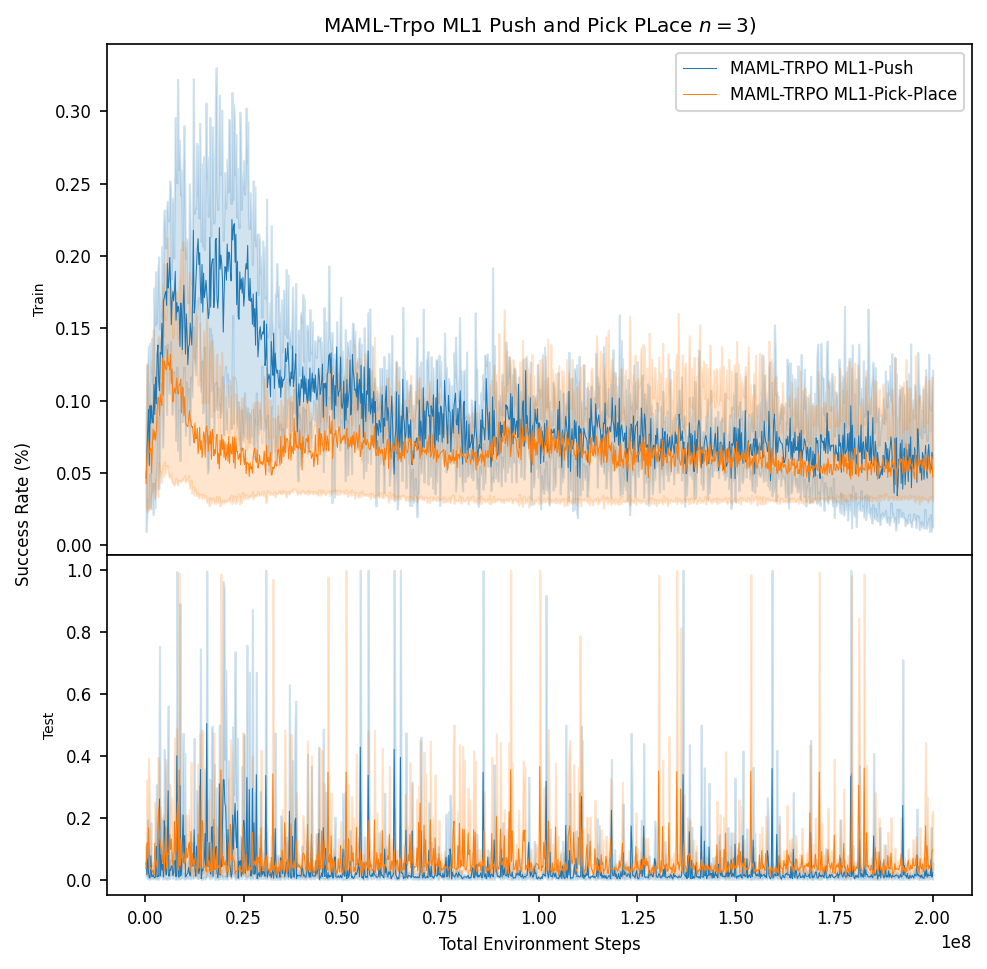

In [12]:
# Seed sensitivity
fig1, axs = plt.subplots(2, 
                         sharex=True,
                         figsize=(6.5,6.5), # use (6.5, 4) for single-column figures
                         tight_layout=True,
                         gridspec_kw={'height_ratios': [3, 2], 'hspace': 0}
                         ) 
train_ax, test_ax = axs

plot_data = {
    
    'MAML-TRPO ML1-Push': [
        'maml_trpo_metaworld_ml1_push_seed=3905',
        'maml_trpo_metaworld_ml1_push_seed=5248',
        'maml_trpo_metaworld_ml1_push_seed=7082',
        
    ],
    'MAML-TRPO ML1-Pick-Place': [
        'maml_trpo_metaworld_ml1_pick_place_seed=2939',
        'maml_trpo_metaworld_ml1_pick_place_seed=4583',
        'maml_trpo_metaworld_ml1_pick_place_seed=7612',
    ],

}

# Smoothing spans
smooth = {
    'MAML-TRPO ML1-Push': 1,
    'MAML-TRPO ML1-Pick-Place': 1,
}

group_df = None
# Plot
labels = []
for name, group in plot_data.items():
    print('Plotting {}...'.format(name))
    dfs = [exp_df[e].copy() for e in group]

#     for e in group:
    # Smoothing
#     dfs = [df.rolling(smooth[name]).mean() for df in dfs]

    # Combined dataframe
    group_df = pd.concat(dfs, keys=group, sort=True)

    # Plot train with 95% confidence interval
    train_rval = sns.lineplot(x='TotalEnvSteps', y='Average/EpisodeMeanMaxGraspReward', ax=train_ax, data=group_df, ci=99, lw=0.5)
    train_color = train_ax.get_lines()[-1].get_color()
    labels.append(name)

    if 'TestSuccessRate' in group_df.columns:
        try:
            sns.lineplot(x='TotalEnvSteps', y='MetaTest/pick-place-v2/EpisodeMeanMaxGraspReward', ax=test_ax, data=group_df, ci=95, lw=0.5, 
                         color=train_color)
        except:
            sns.lineplot(x='TotalEnvSteps', y='MetaTest/push-v2/EpisodeMeanMaxGraspReward', ax=test_ax, data=group_df, ci=95, lw=0.5, 
                         color=train_color)


train_ax.set_title(r'MAML-Trpo ML1 Push and Pick PLace $n=3$)')
train_ax.set_ylabel('Train', fontsize='small')
train_ax.legend(labels, loc='upper right')
# train_ax.set_ylim([0, 10])
test_ax.set_ylabel('Test', fontsize='small')
# test_ax.set_ylim([0, 100])
plt.figtext(0, 0.40, 'Success Rate (%)', rotation='vertical', in_layout=True)
plt.xlabel('Total Environment Steps')
# plt.xlim([0, 150e6])

In [8]:
fig1.show()
fig1.savefig('MAML-Trpo-ML1-Push-and-Pick-Place.png', pad_inches=0, dpi=300)

# ML1 Push, Pick-Place RL2

In [3]:
experiment_data=[
    'rl2_ppo_metaworld_ml1_env_name=pick-place-v2_seed=3735_meta_batch_size=10_n_epochs=2000_episode_per_task=10',
    'rl2_ppo_metaworld_ml1_env_name=pick-place-v2_seed=6687_meta_batch_size=10_n_epochs=2000_episode_per_task=10',
    'rl2_ppo_metaworld_ml1_env_name=pick-place-v2_seed=7899_meta_batch_size=10_n_epochs=2000_episode_per_task=10',
    'rl2_ppo_metaworld_ml1_env_name=push-v2_seed=1376_meta_batch_size=10_n_epochs=2000_episode_per_task=10',
    'rl2_ppo_metaworld_ml1_env_name=push-v2_seed=4702_meta_batch_size=10_n_epochs=2000_episode_per_task=10',
    'rl2_ppo_metaworld_ml1_env_name=push-v2_seed=5314_meta_batch_size=10_n_epochs=2000_episode_per_task=10',
]

In [4]:
DATA_DIR = 'ml1_csv'

data_dir = pathlib.Path(DATA_DIR)
data_dir.mkdir(exist_ok=True)

exp_df = {}
def load_experiments(experiments_list, data_directory):
    dfs = {}
    for e in experiments_list:
        print('Loading {}...'.format(e)) 
        progress = data_directory / f'{e}.csv'
        df = pd.read_csv(progress)
        df = fixup_dataframe(df, e)
        dfs[e] = df
    return dfs



exp_df.update(load_experiments(experiment_data, data_dir))

Loading rl2_ppo_metaworld_ml1_env_name=pick-place-v2_seed=3735_meta_batch_size=10_n_epochs=2000_episode_per_task=10...
Loading rl2_ppo_metaworld_ml1_env_name=pick-place-v2_seed=6687_meta_batch_size=10_n_epochs=2000_episode_per_task=10...
Loading rl2_ppo_metaworld_ml1_env_name=pick-place-v2_seed=7899_meta_batch_size=10_n_epochs=2000_episode_per_task=10...
Loading rl2_ppo_metaworld_ml1_env_name=push-v2_seed=1376_meta_batch_size=10_n_epochs=2000_episode_per_task=10...
Loading rl2_ppo_metaworld_ml1_env_name=push-v2_seed=4702_meta_batch_size=10_n_epochs=2000_episode_per_task=10...
Loading rl2_ppo_metaworld_ml1_env_name=push-v2_seed=5314_meta_batch_size=10_n_epochs=2000_episode_per_task=10...


In [5]:
exp_df['rl2_ppo_metaworld_ml1_env_name=pick-place-v2_seed=3735_meta_batch_size=10_n_epochs=2000_episode_per_task=10']['TestSuccessRate']


0       0.0
1       NaN
2       NaN
3       NaN
4       NaN
       ... 
1065    NaN
1066    NaN
1067    NaN
1068    NaN
1069    NaN
Name: TestSuccessRate, Length: 1070, dtype: float64

Plotting RL2-PPO ML1-Push...
Plotting RL2-PPO ML1-Pick-Place...


Text(0.5, 0, 'Total Environment Steps')

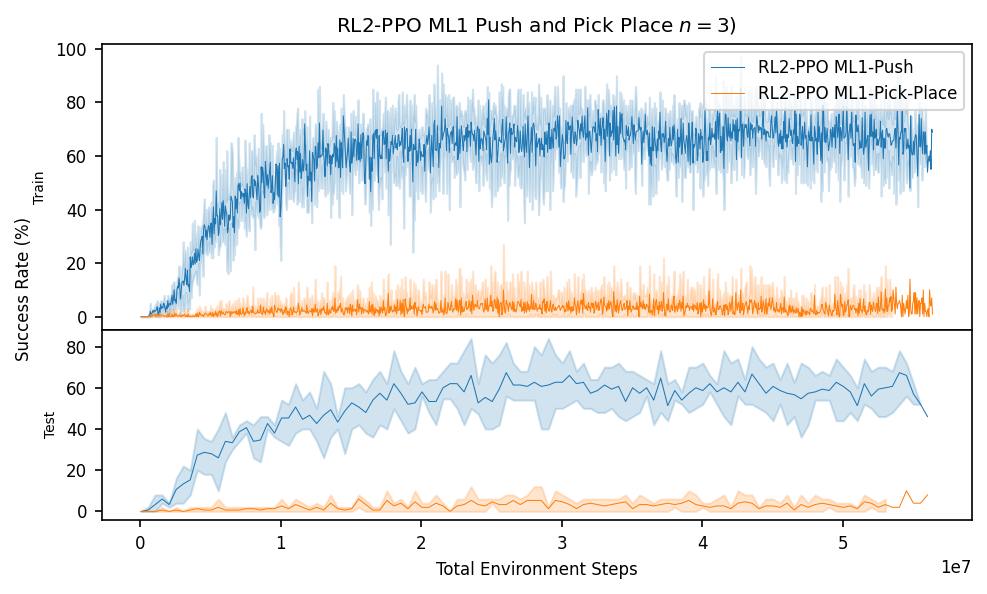

In [6]:
# Seed sensitivity
fig1, axs = plt.subplots(2, 
                         sharex=True,
                         figsize=(6.5,4), # use (6.5, 4) for single-column figures
                         tight_layout=True,
                         gridspec_kw={'height_ratios': [3, 2], 'hspace': 0}
                         ) 
train_ax, test_ax = axs

plot_data = {
    
    'RL2-PPO ML1-Push': [
        'rl2_ppo_metaworld_ml1_env_name=push-v2_seed=1376_meta_batch_size=10_n_epochs=2000_episode_per_task=10',
        'rl2_ppo_metaworld_ml1_env_name=push-v2_seed=4702_meta_batch_size=10_n_epochs=2000_episode_per_task=10',
        'rl2_ppo_metaworld_ml1_env_name=push-v2_seed=5314_meta_batch_size=10_n_epochs=2000_episode_per_task=10',
        
    ],
    'RL2-PPO ML1-Pick-Place': [
        'rl2_ppo_metaworld_ml1_env_name=pick-place-v2_seed=3735_meta_batch_size=10_n_epochs=2000_episode_per_task=10',
        'rl2_ppo_metaworld_ml1_env_name=pick-place-v2_seed=6687_meta_batch_size=10_n_epochs=2000_episode_per_task=10',
        'rl2_ppo_metaworld_ml1_env_name=pick-place-v2_seed=7899_meta_batch_size=10_n_epochs=2000_episode_per_task=10',
    ],

}

# Smoothing spans
smooth = {
    'RL2-PPO ML1-Push': 1,
    'RL2-PPO ML1-Pick-Place': 1,
}

group_df = None
# Plot
labels = []
for name, group in plot_data.items():
    print('Plotting {}...'.format(name))
    dfs = [exp_df[e].copy() for e in group]

#     for e in group:
    # Smoothing
#     dfs = [df.rolling(smooth[name]).mean() for df in dfs]

    # Combined dataframe
    group_df = pd.concat(dfs, keys=group, sort=True)

    # Plot train with 95% confidence interval
    train_rval = sns.lineplot(x='TotalEnvSteps', y='SuccessRate', ax=train_ax, data=group_df, ci=99, lw=0.5)
    train_color = train_ax.get_lines()[-1].get_color()
    labels.append(name)
    if 'TestSuccessRate' in group_df.columns:
        group_df= group_df[group_df['TestSuccessRate'].notna()]
        sns.lineplot(x='TotalEnvSteps', y='TestSuccessRate', ax=test_ax, data=group_df, ci=95, lw=0.5, 
                         color=train_color)

train_ax.set_title(r'RL2-PPO ML1 Push and Pick Place $n=3$)')
train_ax.set_ylabel('Train', fontsize='small')
train_ax.legend(labels, loc='upper right')
# train_ax.set_ylim([0, 10])
test_ax.set_ylabel('Test', fontsize='small')
# test_ax.set_ylim([0, 100])
plt.figtext(0, 0.40, 'Success Rate (%)', rotation='vertical', in_layout=True)
plt.xlabel('Total Environment Steps')
# plt.xlim([0, 150e6])

In [8]:
fig1.show()
fig1.savefig('MAML-Trpo-ML1-Push-and-Pick-Place.png', pad_inches=0, dpi=300)